# EHR A3
## GROUP: B
## MEMBERS: ERNEST CEBALLOS, JÚLIA GALIMANY, ORIOL GALIMANY


In [1]:
library(dplyr)
library(tidyr)
library(tibble)
library(lubridate)
library(readr)
library(stringr)
library(data.table)
library(odbc)
library(RMariaDB)
library(DBI)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
con <- dbConnect(
  drv = RMariaDB::MariaDB(),
  username = "ernest.ceballos",
  password = "EeWot5Bu",
  host = "ehr3.deim.urv.cat",
  dbname = "mimiciiiv14",
  port = 3306
)

# PART 1: COHORT 

### Cohort definition
We performed a retrospective observational study using the Medical Information Mart for Intensive Care III (MIMIC-III), version 1.4, a publicly available database containing de-identified health data from over 40,000 adult and neonatal ICU admissions at Beth Israel Deaconess Medical Center between 2001 and 2012. Our cohort comprised all adult patients aged 16 years or older with at least one ICU admission recorded in the ICUSTAYS table. Age was calculated as the difference in years between the ICU admission time (INTIME) and the patient’s date of birth. For patients with multiple ICU stays, each stay was considered an independent observation. Neonatal and pediatric admissions (age < 16 years) were excluded. The final analytical cohort included all qualifying ICU admissions available in the database, without further exclusion criteria.


In [3]:
# Cohort construction
cohort_model <- tbl(con, "ICUSTAYS") %>%
  inner_join(tbl(con, "ADMISSIONS"), by = c("HADM_ID" = "HADM_ID", "SUBJECT_ID" = "SUBJECT_ID")) %>%
  inner_join(tbl(con, "PATIENTS"), by = c("SUBJECT_ID" = "SUBJECT_ID")) %>%
  inner_join(tbl(con, "DIAGNOSES_ICD"), by = c("HADM_ID" = "HADM_ID", "SUBJECT_ID" = "SUBJECT_ID")) %>%
  mutate(
    age = year(INTIME) - year(DOB)
  ) %>%
  filter(age >= 16) %>%
  select(
    HADM_ID,
    SUBJECT_ID,
    ICUSTAY_ID,
    age,
    GENDER,
    ETHNICITY,
    INSURANCE,
    ICD9_CODE,
    HOSPITAL_EXPIRE_FLAG
  ) %>%
  collect()

colnames(cohort_model) <- tolower(colnames(cohort_model))

head(cohort_model)

hadm_id,subject_id,icustay_id,age,gender,ethnicity,insurance,icd9_code,hospital_expire_flag
<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
145834,3,211552,76,M,WHITE,Medicare,0389,0
145834,3,211552,76,M,WHITE,Medicare,78559,0
145834,3,211552,76,M,WHITE,Medicare,5849,0
145834,3,211552,76,M,WHITE,Medicare,4275,0
145834,3,211552,76,M,WHITE,Medicare,41071,0
145834,3,211552,76,M,WHITE,Medicare,4280,0


The final cohort must include an explicit indicator of whether each admission has sepsis or not. This is necessary because the icd9_codes table may contain multiple ICD-9 codes for the same hadm_id, meaning that a single hospital admission can appear multiple times.

To address this, a new binary column called sepsis is created. For each hadm_id, this column is set to 1 if at least one of the associated ICD-9 codes corresponds to sepsis, and 0 otherwise. In this way, each admission is uniquely represented while correctly capturing the presence or absence of sepsis.

In [4]:
cohort_final <- cohort_model %>%
  mutate(sepsis = if_else(
    str_starts(icd9_code, "038") | 
      icd9_code %in% c("99591", "99592", "78552"), 
    1, 0))

In [5]:
head(cohort_final,5)

hadm_id,subject_id,icustay_id,age,gender,ethnicity,insurance,icd9_code,hospital_expire_flag,sepsis
<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
145834,3,211552,76,M,WHITE,Medicare,0389,0,1
145834,3,211552,76,M,WHITE,Medicare,78559,0,0
145834,3,211552,76,M,WHITE,Medicare,5849,0,0
145834,3,211552,76,M,WHITE,Medicare,4275,0,0
145834,3,211552,76,M,WHITE,Medicare,41071,0,0


In [6]:
dim(cohort_final)

[1] 658810     10

Next, the data are grouped by SUBJECT_ID, HADM_ID, and ICUSTAY_ID. At this stage, each ICUSTAY_ID may still be associated with multiple ICD-9 codes, including several related to sepsis.

To ensure that sepsis codes are retained when present, rows with sepsis = 1 are ordered first within each group. The data are then grouped by SUBJECT_ID, HADM_ID, and ICUSTAY_ID, and only the first row of each group is selected. Because sepsis-positive rows are prioritized at the top, this approach ensures that, whenever sepsis is present for a given ICU stay, the corresponding sepsis ICD-9 code is kept instead of a non-sepsis code.

In [7]:
cohort_unique <- cohort_final %>%
  group_by(subject_id, hadm_id, icustay_id) %>%
  arrange(desc(sepsis)) %>% #Sepsis registers appears first
  slice(1) %>% #takes only the very first row of each group
  ungroup()

In [9]:
dim(cohort_unique)

[1] 53424    10

In [41]:
#Prepare the dataframe by indicating which columns are treated as factors
fact_cols <- c('hadm_id', 'subject_id', 'icustay_id', 'hospital_expire_flag', 'sepsis', 'ethnicity', 'insurance', 'icd9_code')
cohort_unique[fact_cols] = lapply(cohort_unique[fact_cols],as.factor)
head(cohort_unique)

hadm_id,subject_id,icustay_id,age,gender,ethnicity,insurance,icd9_code,hospital_expire_flag,sepsis
<fct>,<fct>,<fct>,<int>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>
145834,3,211552,76,M,WHITE,Medicare,0389,0,1
185777,4,294638,48,F,WHITE,Private,042,0,0
107064,6,228232,66,F,WHITE,Medicare,40391,0,0
150750,9,220597,41,M,UNKNOWN/NOT SPECIFIED,Medicaid,431,1,0
194540,11,229441,50,F,WHITE,Private,1913,0,0
112213,12,232669,72,M,WHITE,Medicare,1570,1,0


In [11]:
patients_sepsis <- cohort_unique %>%
    filter(sepsis ==1)

head(patients_sepsis)

hadm_id,subject_id,icustay_id,age,gender,ethnicity,insurance,icd9_code,hospital_expire_flag,sepsis
<fct>,<fct>,<fct>,<int>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>
145834,3,211552,76,M,WHITE,Medicare,0389,0,1
111970,21,216859,88,M,WHITE,Medicare,0388,1,1
176176,33,296681,82,M,UNKNOWN/NOT SPECIFIED,Medicare,0389,0,1
185910,38,248910,76,M,WHITE,Medicare,0389,0,1
189535,61,217135,56,M,WHITE,Private,0389,1,1
116009,62,216609,69,M,PATIENT DECLINED TO ANSWER,Medicare,03849,0,1


In [12]:
#Checking for NA values
anyNA(cohort_unique)
sum(is.na(cohort_unique))
summary(cohort_unique)

[1] TRUE

[1] 14

    hadm_id        subject_id      icustay_id         age        
 163281 :    7   13033  :   41   200001 :    1   Min.   : 16.00  
 186706 :    7   109    :   38   200003 :    1   1st Qu.: 53.00  
 109520 :    6   11861  :   35   200006 :    1   Median : 66.00  
 123178 :    6   5060   :   31   200007 :    1   Mean   : 74.73  
 175448 :    6   19213  :   25   200009 :    1   3rd Qu.: 78.00  
 108976 :    5   20643  :   25   200010 :    1   Max.   :311.00  
 (Other):53387   (Other):53229   (Other):53418                   
    gender                           ethnicity          insurance    
 Length:53424       WHITE                 :37908   Government: 1443  
 Class :character   BLACK/AFRICAN AMERICAN: 4751   Medicaid  : 4734  
 Mode  :character   UNKNOWN/NOT SPECIFIED : 4303   Medicare  :29811  
                    HISPANIC OR LATINO    : 1378   Private   :16854  
                    OTHER                 : 1178   Self Pay  :  582  
                    UNABLE TO OBTAIN      :  846    

In [13]:
#There are only 7 NA values in icd9_code (which is why there are 7 NA values in sepsis). For 7 rows, we will eliminate them. 
cohort_unique <- cohort_unique %>% drop_na()

# PART 2: SEPSIS PREVALENCE AND MORTALITY

## Prevalence

In [14]:
sepsis_prevalence <- cohort_unique %>%
  summarise(
    total_icu_admissions = n(),
    sepsis_icu_admissions = sum(sepsis == "1", na.rm = TRUE),
    sepsis_prevalence = (sepsis_icu_admissions / total_icu_admissions) * 100
  )

sepsis_prevalence

total_icu_admissions,sepsis_icu_admissions,sepsis_prevalence
<int>,<int>,<dbl>
53417,7261,13.59305


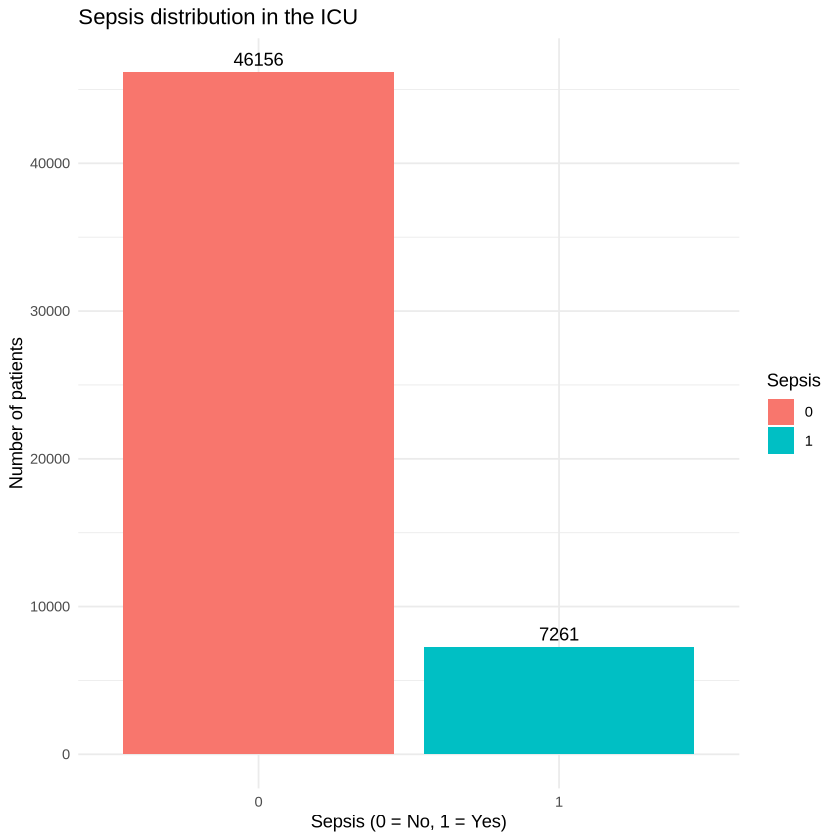

In [17]:
library(ggplot2)

ggplot(cohort_unique, aes(x = sepsis, fill = sepsis)) +
  geom_bar() +
  geom_text(stat='count', aes(label=after_stat(count)), vjust=-0.5) +
  labs(title = "Sepsis distribution in the ICU",
       x = "Sepsis (0 = No, 1 = Yes)",
       y = "Number of patients",
       fill = "Sepsis") +
  theme_minimal()

### Sepsis prevalence by gender

In [18]:
prevalence_gender <- cohort_unique %>%
  group_by(gender) %>%
  summarise(
    total_admissions = n(),
    sepsis_cases = sum(sepsis == "1"),
    non_sepsis_cases = sum(sepsis == "0"),
    prevalence_percent = (sepsis_cases / total_admissions) * 100
  )

prevalence_gender

gender,total_admissions,sepsis_cases,non_sepsis_cases,prevalence_percent
<chr>,<int>,<int>,<int>,<dbl>
F,23323,3179,20144,13.63032
M,30094,4082,26012,13.56417


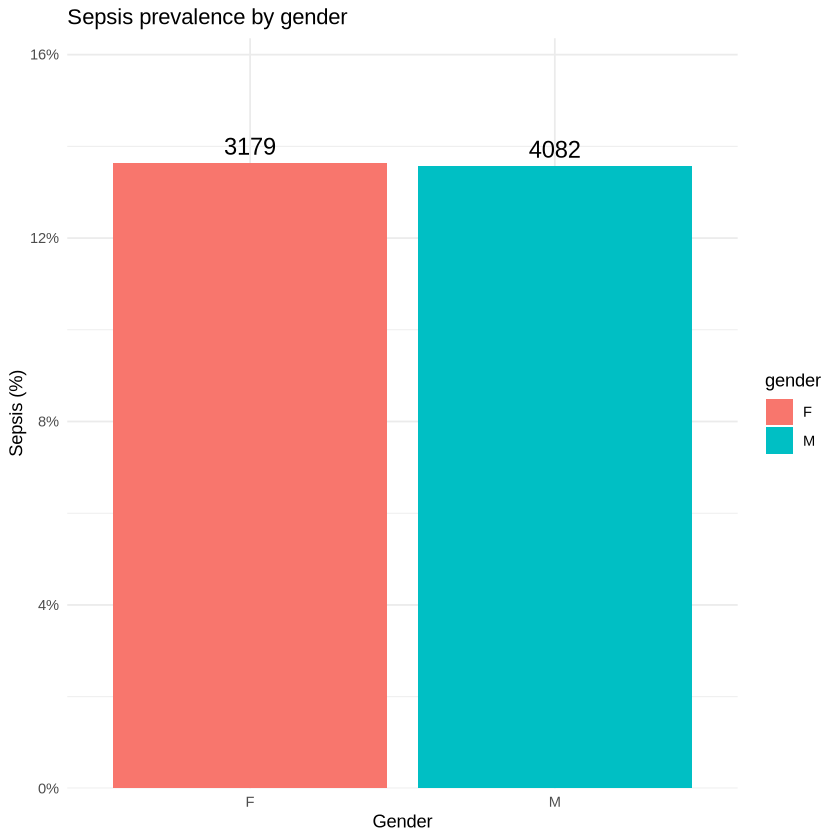

In [40]:
ggplot(prevalence_gender, aes(x = gender, y = prevalence_percent, fill = gender)) +
  geom_col() +
  geom_text(aes(label = sepsis_cases), 
            vjust = -0.5,
            size = 5) +
  scale_y_continuous(labels = function(x) paste0(x, "%"),
                     expand = expansion(mult = c(0, 0.2))) +
  labs(title = "Sepsis prevalence by gender",
       y = "Sepsis (%)",
       x = "Gender") +
  theme_minimal()

### Sepsis prevalence by age

In [20]:
prevalence_age <- cohort_unique %>%
  mutate(age_group = cut(age, 
                         breaks = c(16, 40, 60, 80, Inf), 
                         labels = c("16-40", "40-60", "60-80", "80+"),
                         right = FALSE)) %>%
  group_by(age_group) %>%
  summarise(
    total_admissions = n(),
    sepsis_cases = sum(sepsis == "1"),
    prevalence_prop = sepsis_cases / total_admissions
  ) %>%
  # Delate NA if there are unknown ages
  filter(!is.na(age_group))

prevalence_age

age_group,total_admissions,sepsis_cases,prevalence_prop
<fct>,<int>,<int>,<dbl>
16-40,5118,428,0.08362642
40-60,14678,1862,0.12685652
60-80,22252,3155,0.14178501
80+,11369,1816,0.15973261


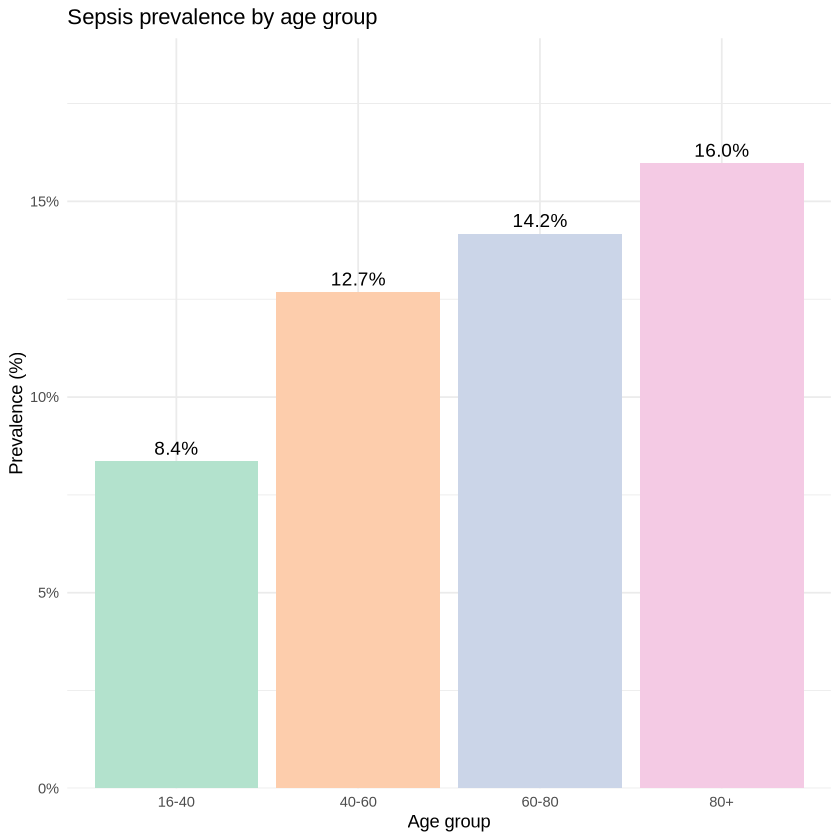

In [21]:
ggplot(prevalence_age, aes(x = age_group, y = prevalence_prop, fill = age_group)) +
  geom_col() +
  geom_text(aes(label = scales::percent(prevalence_prop, accuracy = 0.1)), 
            vjust = -0.5, size = 4) +
  scale_y_continuous(labels = scales::percent, 
                     expand = expansion(mult = c(0, 0.2))) +
  scale_fill_brewer(palette = "Pastel2") +
  labs(title = "Sepsis prevalence by age group",
       x = "Age group",
       y = "Prevalence (%)") +
  theme_minimal() +
  theme(legend.position = "none")

## Mortality

hospital_expire_flag,count,Percentage_Status
<fct>,<int>,<dbl>
0,4896,67.42873
1,2365,32.57127


Sepsis mortality rate is 32.57 %

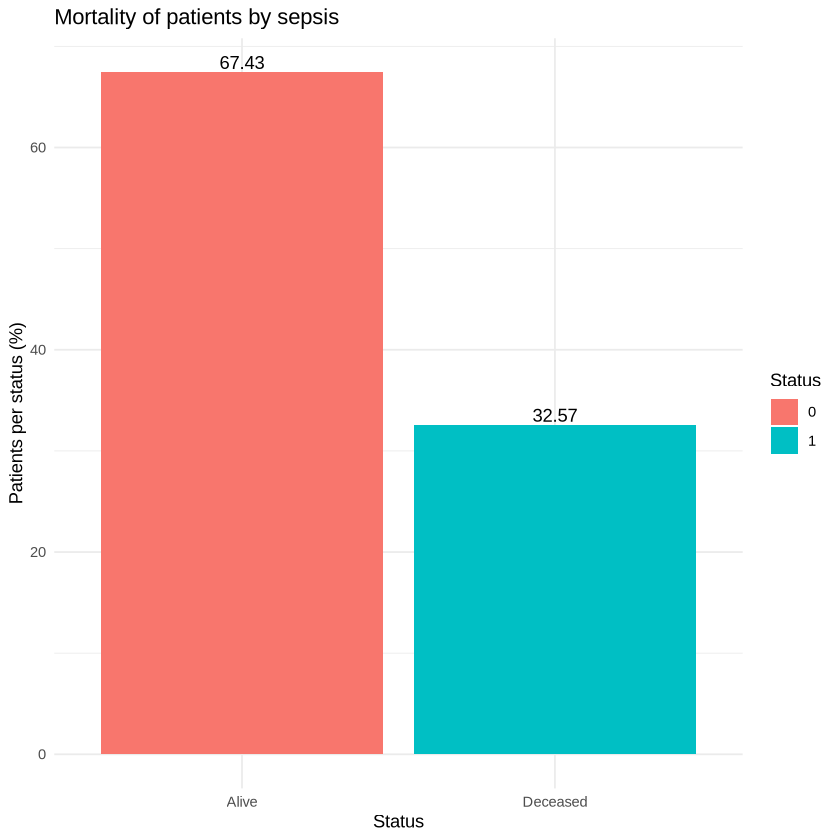

In [22]:
#With sepsis
df2 <- cohort_unique%>%
    filter(sepsis == 1) %>%
    select(hospital_expire_flag) %>%
    group_by(hospital_expire_flag)%>%
    summarise(count = n())%>%
    mutate(Percentage_Status = count / sum(count) * 100)
head(df2)

mortality_sepsis <- df2 %>%
  filter(hospital_expire_flag == 1) %>%
  pull(Percentage_Status)
cat("Sepsis mortality rate is", round(mortality_sepsis,2), "%")

ggplot(df2,
       aes(x= factor(hospital_expire_flag, levels = c(0,1), labels = c('Alive','Deceased')),
           y=Percentage_Status, 
           fill = hospital_expire_flag, 
           label=round(Percentage_Status,2))
       ) +
  geom_col() +
  geom_text(position=position_dodge(0.5), vjust=-0.25) +
  labs(x = 'Status',
      y = 'Patients per status (%)',
      title = 'Mortality of patients by sepsis',
      fill = 'Status') + 
  theme_minimal()

hospital_expire_flag,count,Percentage_Status
<fct>,<int>,<dbl>
0,41981,90.954589
1,4175,9.045411


Mortality rate without sepsis is 9.05 %

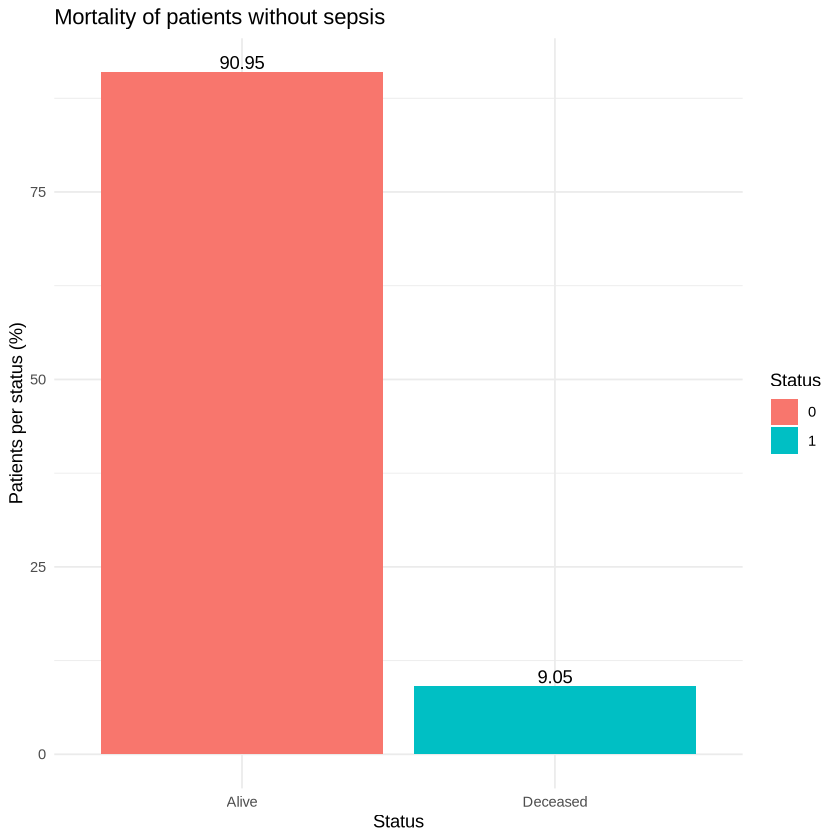

In [23]:
#Without sepsis
df2 <- cohort_unique%>%
    filter(sepsis == 0) %>%
    select(hospital_expire_flag) %>%
    group_by(hospital_expire_flag)%>%
    summarise(count = n())%>%
    mutate(Percentage_Status = count / sum(count) * 100)
head(df2)

mortality_sepsis <- df2 %>%
  filter(hospital_expire_flag == 1) %>%
  pull(Percentage_Status)
cat("Mortality rate without sepsis is", round(mortality_sepsis,2), "%")

ggplot(df2,
       aes(x= factor(hospital_expire_flag, levels = c(0,1), labels = c('Alive','Deceased')),
           y=Percentage_Status, 
           fill = hospital_expire_flag, 
           label=round(Percentage_Status,2))
       ) +
  geom_col() +
  geom_text(position=position_dodge(0.5), vjust=-0.25) +
  labs(x = 'Status',
      y = 'Patients per status (%)',
      title = 'Mortality of patients without sepsis',
      fill = 'Status') + 
  theme_minimal()

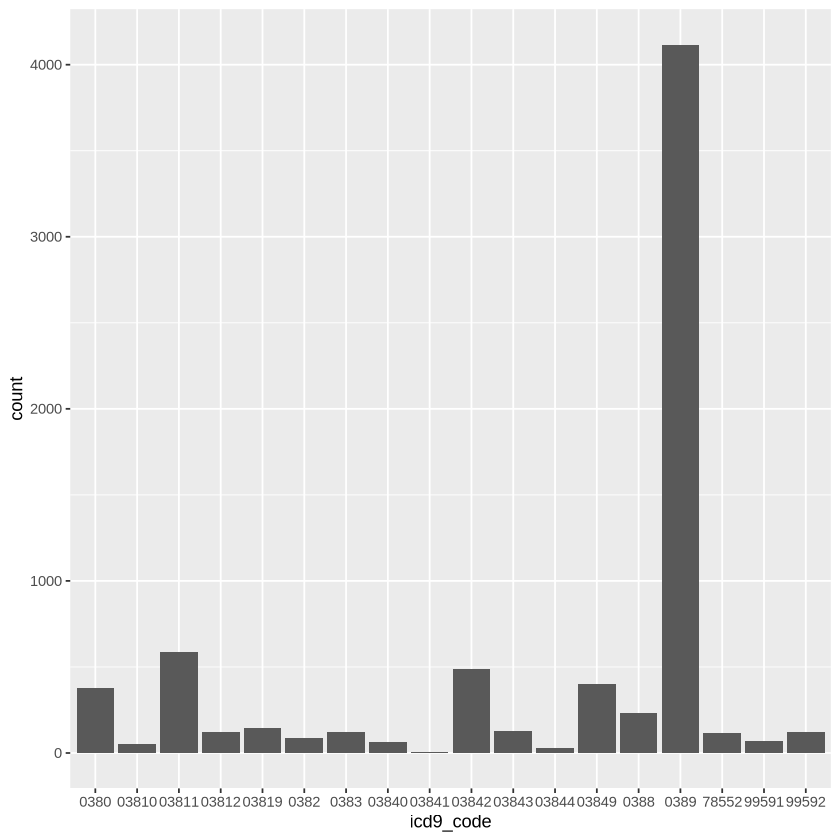

In [24]:
#Petit apunt no se si es un problema pero al icd9_code com que prioritzo sempre el mes baix, molts dels records son agafant el matex icd9_code
ggplot(patients_sepsis, aes(x=icd9_code)) + geom_bar()

# PART 3: LOGISTIC REGRESSION

We build a logistic regression model to evaluate whether mortality among ICU patients with sepsis can be predicted using the following predictor variables: age, gender, ethnicity, insurance, and ICD-9 code. The outcome variable is hospital_expire_flag, which indicates whether the patient died during the hospital stay.

In [25]:
#install.packages("caTools")

In [26]:
library(caTools)

In [27]:
#Splitting the data for training (90%) and testing(10%)
set.seed(100)
spl = sample.split(patients_sepsis$hospital_expire_flag, SplitRatio = 0.9)
train = subset(patients_sepsis, spl == TRUE)
test = subset(patients_sepsis, spl == FALSE)

In [28]:
logistic <- glm(hospital_expire_flag ~ age + gender + ethnicity + insurance + icd9_code, data = train, family = 'binomial')
summary(logistic)


Call:
glm(formula = hospital_expire_flag ~ age + gender + ethnicity + 
    insurance + icd9_code, family = "binomial", data = train)

Coefficients:
                                                                    Estimate
(Intercept)                                                       -7.720e-01
age                                                                1.233e-03
genderM                                                            2.256e-02
ethnicityAMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE  1.405e+01
ethnicityASIAN                                                    -1.078e+00
ethnicityASIAN - ASIAN INDIAN                                     -1.773e+00
ethnicityASIAN - CAMBODIAN                                        -1.683e+00
ethnicityASIAN - CHINESE                                          -3.669e-01
ethnicityASIAN - FILIPINO                                          1.430e+01
ethnicityASIAN - KOREAN                                           -2.088e-01
ethn

In [29]:
predict_test <- predict(logistic, type = "response", newdata = test)
head(predict_test)

1         2         3         4         5         6 
0.3687688 0.4856561 0.2876763 0.3368956 0.3615382 0.2922448

In [30]:
#ROC Curve 
library(pROC)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [31]:
roc_curve <- roc(response = test$hospital_expire_flag, predictor = predict_test)
auc_value <- auc(roc_curve)
cat('AUC:',round(auc_value,3))

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC: 0.622

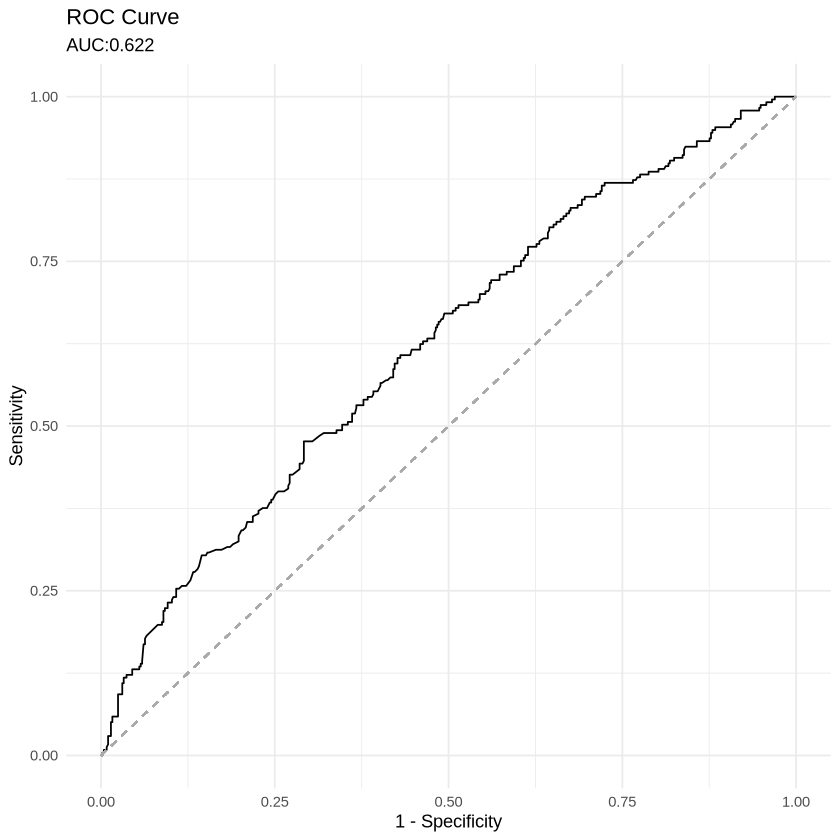

In [32]:
ggroc(data=roc_curve, legacy.axes = TRUE) +
    geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), 
               color = "darkgrey", linetype = "dashed") + #The diagonal line
  theme_minimal() + 
  labs(title = "ROC Curve", 
       subtitle = paste0("AUC:", round(auc_value, 3)),
       x = "1 - Specificity", 
       y = "Sensitivity") 

In [33]:
#Optimal threshold
coords <- coords(roc_curve, "best", best.method = "closest.topleft")
best_threshold <- coords$threshold

cat("Optimal threshold based on ROC curve:", best_threshold, "\n")


Optimal threshold based on ROC curve: 0.3340145 


In [34]:
#ConFusion matrix
predicted_class <- ifelse(predict_test >= best_threshold, 1, 0)
confusion_matrix <- table(test$hospital_expire_flag, predicted_class)
accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
confusion_matrix
cat("Accuracy:", accuracy, "\n") #The model is correct % of the time


   predicted_class
      0   1
  0 281 209
  1  94 143

Accuracy: 0.5832187 


In [35]:
TN <- confusion_matrix[1,1] 
FP <- confusion_matrix[1,2] 
FN <- confusion_matrix[2,1] 
TP <- confusion_matrix[2,2] 

Sensitivity <- TP / (TP + FN)
Specificity <- TN / (TN + FP)
PPV <- TP / (TP + FP)
NPV <- TN / (TN + FN)

cat("Sensitivity: ", Sensitivity, "\n")
cat("Specificity: ", Specificity, "\n")
cat("PPV or Precision:",PPV, "\n")
cat("NPV:",NPV, "\n")

Sensitivity:  0.6033755 
Specificity:  0.5734694 
PPV or Precision: 0.40625 
NPV: 0.7493333 


### Model Premises

We assume the independence of observations (note that sometimes the same hadm_id can contribute to multiple icustay_id, so maybe some observations arent completly independent between them, also the same subject_id may contribute to differnet hadm_id, so i'm not sure of this part). We can put it as a limitations, that as the same subject can contribute to mutliple hadm_id, and the same hadm-id can contribute to multiple icustay_id, this premise is not a full ckeck. 

In [38]:
#install.packages("car")

also installing the dependencies ‘gtable’, ‘S7’, ‘ggplot2’, ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘rbibutils’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘boot’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘Rdpack’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’


Warning message in install.packages("car"):
“installation of package ‘nloptr’ had non-zero exit status”
Warning message in install.packages("car"):
“installation of package ‘lme4’ had non-zero exit status”
Warning message in install.packages("car"):
“installation of package ‘pbkrtest’ had non-zero exit status”
Warning message in install.packages("car"):
“installation of package ‘car’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [39]:
#VIF Premise
library(car)
vif(logistic)

ERROR: Error in library(car): there is no package called ‘car’
